In [1]:
from typing import NamedTuple
import jax
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from glad.model import GLAD, MaxVoting
import tensorflow_probability.substrates.jax.distributions as tfd

In [2]:
seed = jax.random.PRNGKey(13)
true_z = tfd.Bernoulli(probs=0.5).sample(2000, seed=seed)
true_alpha = tfd.Normal(loc=1.0, scale=1.0).sample(20, seed=seed)
true_log_beta = tfd.Normal(loc=1.0, scale=1.0).sample(2000, seed=seed)
alpha_beta = jnp.einsum("a,b->ab", true_alpha, jnp.exp(true_log_beta))
dataset = tfd.Bernoulli(logits=alpha_beta).sample(seed=seed)
labelers_dataset = jnp.where(dataset == 1, true_z.astype(bool), ~true_z.astype(bool)).T.astype(int)

In [3]:
max_model = MaxVoting()
max_model.fit(labelers_dataset)
(max_model.result() == true_z).mean()

DeviceArray(0.959, dtype=float32)

In [4]:
model = GLAD(num_tasks=labelers_dataset.shape[0], num_labelers=labelers_dataset.shape[1])
model.fit(labelers_dataset)

2021-06-11 16:06:44.793 | INFO     | glad.model:fit:131 - Final Log-Likelihood: 11193.3535


In [5]:
result = model.result()
(true_z == result).mean()

DeviceArray(0.9885, dtype=float32)

In [7]:
jnp.corrcoef(model.alpha, true_alpha)

DeviceArray([[1.        , 0.99279493],
             [0.992795  , 1.        ]], dtype=float32)

In [8]:
jnp.corrcoef(model.log_beta, true_log_beta)

DeviceArray([[1.        , 0.8076474 ],
             [0.80764747, 1.        ]], dtype=float32)

In [13]:
class Information(NamedTuple):
    glad: GLAD
    dataset: jnp.ndarray
    max_result: jnp.ndarray
    glad_result: jnp.ndarray
    corr_alpha: jnp.ndarray
    corr_beta: jnp.ndarray

In [20]:
def compare_glad(num_operators: int, seed: int = 13):
    seed = jax.random.PRNGKey(seed)
    true_z = tfd.Bernoulli(probs=0.5).sample(2000, seed=seed)
    true_alpha = tfd.Normal(loc=1.0, scale=1.0).sample(num_operators, seed=seed)
    true_log_beta = tfd.Normal(loc=1.0, scale=1.0).sample(2000, seed=seed)
    # Computation
    alpha_beta = jnp.einsum("a,b->ab", true_alpha, jnp.exp(true_log_beta))
    dataset = tfd.Bernoulli(logits=alpha_beta).sample(seed=seed)
    labelers_dataset = jnp.where(dataset == 1, true_z.astype(bool), ~true_z.astype(bool)).T.astype(int)
    # Max voting
    max_voting = MaxVoting()
    max_voting.fit(labelers_dataset)
    max_result = (true_z == max_voting.result()).mean()
    # GLAD
    model = GLAD()
    model.fit(labelers_dataset)
    glad_result = (true_z == model.result()).mean()
    corr_alpha = jnp.corrcoef(model.alpha, true_alpha)[0, -1]
    corr_beta = jnp.corrcoef(model.log_beta, true_log_beta)[0, -1]
    return Information(
        glad=model,
        dataset=labelers_dataset,
        max_result=max_result,
        glad_result=glad_result,
        corr_alpha=corr_alpha,
        corr_beta=corr_beta,
    )

In [21]:
list(range(4, 22, 2))

[4, 6, 8, 10, 12, 14, 16, 18, 20]

In [22]:
infos = []
for num_operators in range(4, 22, 2):
    infos.append(compare_glad(num_operators))

2021-05-28 21:00:58.387 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 2112.4229
2021-05-28 21:01:10.422 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 2236.8076
2021-05-28 21:01:23.269 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 3577.0068
2021-05-28 21:01:36.300 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 3349.4734
2021-05-28 21:01:48.563 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 5465.2026
2021-05-28 21:02:01.255 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 7339.7412
2021-05-28 21:02:13.358 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 12707.4600
2021-05-28 21:02:25.343 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 9667.0410
2021-05-28 21:02:35.218 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 11302.7715


In [24]:
[(x.max_result, x.corr_beta) for x in infos]

[(DeviceArray(0.821, dtype=float32), DeviceArray(0.56663877, dtype=float32)),
 (DeviceArray(0.9565, dtype=float32), DeviceArray(0.5058308, dtype=float32)),
 (DeviceArray(0.9485, dtype=float32), DeviceArray(0.6987369, dtype=float32)),
 (DeviceArray(0.961, dtype=float32), DeviceArray(0.7453797, dtype=float32)),
 (DeviceArray(0.97, dtype=float32), DeviceArray(0.7395641, dtype=float32)),
 (DeviceArray(0.951, dtype=float32), DeviceArray(0.81185114, dtype=float32)),
 (DeviceArray(0.945, dtype=float32), DeviceArray(0.7602661, dtype=float32)),
 (DeviceArray(0.964, dtype=float32), DeviceArray(0.7814377, dtype=float32)),
 (DeviceArray(0.959, dtype=float32), DeviceArray(0.7648077, dtype=float32))]

In [27]:
ola = infos[0]
ola
infos[0] = Information(
    glad=ola.glad,
    dataset=ola.dataset,
    max_result=ola.max_result,
    glad_result=1 - ola.glad_result,
    corr_alpha=-ola.corr_alpha,
    corr_beta=ola.corr_beta
)

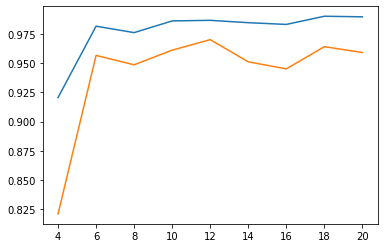

In [28]:
sns.lineplot(x=list(range(4, 22, 2)), y=[x.glad_result.item() for x in infos])
sns.lineplot(x=list(range(4, 22, 2)), y=[x.max_result.item() for x in infos])
plt.show()

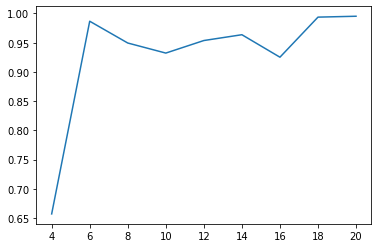

In [32]:
sns.lineplot(x=list(range(4, 22, 2)), y=[x.corr_alpha.item() for x in infos])
plt.show()

In [85]:
# ola = infos2[0]
# ola
# # infos2[0] = Information(
# #     glad=ola.glad,
# #     dataset=ola.dataset,
# #     max_result=ola.max_result,
# #     glad_result=1 - ola.glad_result,
# #     corr=-ola.corr,
# # )
# infos2[5] = Information(
#     glad=infos2[5].glad,
#     dataset=infos2[5].dataset,
#     max_result=infos2[5].max_result,
#     glad_result=1 - infos2[5].glad_result,
#     corr=-infos2[5].corr,
# )
# infos2[-1] = Information(
#     glad=infos2[-1].glad,
#     dataset=infos2[-1].dataset,
#     max_result=infos2[-1].max_result,
#     glad_result=1 - infos2[-1].glad_result,
#     corr=-infos2[-1].corr,
# )

In [33]:
infos2 = []
for num_operators in range(4, 22, 2):
    infos2.append(compare_glad(num_operators, seed=42))

2021-05-28 21:16:26.459 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 1399.3140
2021-05-28 21:16:36.975 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 2747.0210
2021-05-28 21:16:47.279 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 3967.5173
2021-05-28 21:16:57.866 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 7703.5142
2021-05-28 21:17:09.167 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 9103.9785
2021-05-28 21:17:20.164 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 6845.8066
2021-05-28 21:17:30.625 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 10277.5811
2021-05-28 21:17:40.622 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 9135.3154
2021-05-28 21:17:51.562 | INFO     | glad.model:fit:115 - Final Log-Likelihood: 11602.6357


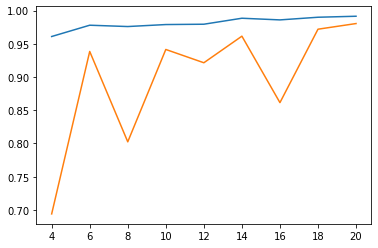

In [86]:
sns.lineplot(x=list(range(4, 22, 2)), y=[x.glad_result.item() for x in infos2])
sns.lineplot(x=list(range(4, 22, 2)), y=[x.max_result.item() for x in infos2])
plt.show()

<AxesSubplot:>

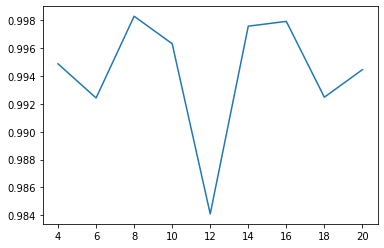

In [87]:
sns.lineplot(x=list(range(4, 22, 2)), y=[x.corr.item() for x in infos2])